In [ ]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
creds = "/Users/srdeo/OneDrive - Copart, Inc/secrets/cprtpr-datastewards-sp1-614d7e297848 (1).json"
client = bigquery.Client.from_service_account_json(json_credentials_path=creds)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=creds)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import warnings
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

### Extracting Churn and Non-Churn PMs for June 2025

In [ ]:
query1 = f"""
    SELECT
        m.owner_mbr_nbr,
        m.mbr_nbr,
        m.mbr_type,
        m.mbr_mbrshp_type_cd,
        e.event_type,
        e.event_value,
        DATE_TRUNC(e.event_value, MONTH) AS event_month,
        'April' AS month_label,
        CASE
            WHEN m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST' THEN 1
            WHEN m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date' THEN 0
            ELSE NULL
        END AS churn
    FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact m
    JOIN `cprtpr-dataplatform-sp1`.usmart.v_us_member_events_fact e
        ON m.mbr_nbr = e.mbr_nbr
    WHERE (
        (m.mbr_type = 'PREMIER' AND e.event_type = 'Member Premier Renewal Paid Date') OR
        (m.mbr_type = 'LPSDPREMIER' AND e.event_type = 'MEMBER TYPE UPDATED FROM PREMIER TO GUEST')
    )
      AND e.event_value BETWEEN '2025-06-01' AND '2025-06-30'
      """

data1 = client.query(query1).to_dataframe()

In [ ]:
data1
print(data1.shape)
print(data1.isnull().sum())
print(data1['churn'].value_counts())

* Below query extracts unique owner mbr from above and converts into SQL IN clause format

In [ ]:
owner_ids = data1['owner_mbr_nbr'].unique().tolist()
owner_ids_str = ", ".join([str(x) for x in owner_ids])

In [ ]:
churn_list = data1[data1['churn'] == 1]['owner_mbr_nbr'].unique().tolist()

In [ ]:
len(owner_ids)

* Below query extracts PMs (churn /non-churn in April) and their data between oct 2024 - mar 2025 excluding CDS

In [ ]:
query2 = f"""
WITH cds_members AS (
  SELECT DISTINCT buyer_nbr
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact
  WHERE inv_dt BETWEEN '2024-12-01' AND '2025-05-31'
    AND seller_parent_company = 'CDS'
),

lot_fact_filtered AS (
  SELECT
    lot_nbr,
    inv_dt,
    seller_parent_company,
    high_bid_amt,
    buyer_nbr
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_lot_fact
  WHERE inv_dt BETWEEN '2024-12-01' AND '2025-05-31'
    AND seller_parent_company != 'CDS'
),

member_info AS (
  SELECT
    owner_mbr_nbr,
    mbr_nbr,
    mbr_state,
    mbr_country,
    member_sgmnt_type
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_member_fact
  WHERE owner_mbr_nbr IN ({owner_ids_str})
),

bids_placed AS (
  SELECT
    m.owner_mbr_nbr,
    m.mbr_nbr,
    m.mbr_state,
    m.mbr_country,
    m.member_sgmnt_type,
    AVG(CASE WHEN l.lot_nbr IS NOT NULL THEN b.bid_amt ELSE NULL END) AS avg_max_bid_amt,
    COUNTIF(l.inv_dt IS NOT NULL) AS total_bids_on_lots_sold
  FROM member_info m
  LEFT JOIN `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
    ON m.mbr_nbr = b.buyer_nbr
  LEFT JOIN lot_fact_filtered l
    ON b.lot_nbr = l.lot_nbr
  GROUP BY m.owner_mbr_nbr, m.mbr_nbr, m.mbr_state, m.mbr_country, m.member_sgmnt_type
),

lots_bid_on AS (
  SELECT
    b.buyer_nbr AS mbr_nbr,
    COUNT(DISTINCT b.lot_nbr) AS total_lots_placed_bids_on
  FROM `cprtpr-dataplatform-sp1`.usviews.v_us_bids_fact b
  JOIN lot_fact_filtered l
    ON b.lot_nbr = l.lot_nbr
  GROUP BY b.buyer_nbr
),

lots_won AS (
  SELECT
    l.buyer_nbr AS mbr_nbr,
    AVG(l.high_bid_amt) AS AvgSellingPrice,
    COUNT(DISTINCT l.lot_nbr) AS total_lots_won
  FROM lot_fact_filtered l
  GROUP BY l.buyer_nbr
)

SELECT
  bp.owner_mbr_nbr,
  bp.mbr_nbr,
  bp.total_bids_on_lots_sold,
  lb.total_lots_placed_bids_on,
  w.total_lots_won,
  bp.avg_max_bid_amt,
  w.AvgSellingPrice,
  bp.mbr_state,
  bp.mbr_country,
  bp.member_sgmnt_type
FROM bids_placed bp
LEFT JOIN lots_bid_on lb ON bp.mbr_nbr = lb.mbr_nbr
LEFT JOIN lots_won w ON bp.mbr_nbr = w.mbr_nbr
WHERE bp.mbr_nbr NOT IN (SELECT buyer_nbr FROM cds_members)
"""

data2 = client.query(query2).to_dataframe()

In [29]:
data2
print(data2.shape)
print(data2.isnull().sum())
print(data2['owner_mbr_nbr'].nunique())

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type
0,589054,589054,192,44,2,1707.031250,3525.000000,HN,HND,Exporter
1,434001,434001,20,6,<NA>,955.000000,NaN,CO,USA,Consumer
2,505436,505436,0,<NA>,<NA>,NaN,NaN,VA,USA,Consumer
3,584638,584638,3,1,<NA>,3650.000000,NaN,QC,CAN,Exporter
4,937270,937270,519,262,9,4134.421965,7327.777778,NJ,USA,Dealer
...,...,...,...,...,...,...,...,...,...,...
5315,664419,664419,0,<NA>,<NA>,NaN,NaN,NJ,USA,Consumer
5316,504238,504238,0,<NA>,<NA>,NaN,NaN,NY,USA,Consumer
5317,357367,357367,112,14,<NA>,10378.125000,NaN,MN,USA,Consumer
5318,431845,431845,0,<NA>,<NA>,NaN,NaN,AK,USA,General Business


(5320, 10)
owner_mbr_nbr                   0
mbr_nbr                         0
total_bids_on_lots_sold         0
total_lots_placed_bids_on    3237
total_lots_won               4115
avg_max_bid_amt              3237
AvgSellingPrice              4115
mbr_state                       0
mbr_country                     0
member_sgmnt_type             339
dtype: int64
5320


In [ ]:
data2_copy = data2.copy()

In [13]:
data2_copy['total_lots_placed_bids_on'] = data2_copy['total_lots_placed_bids_on'].fillna(0)
data2_copy['total_lots_won'] = data2_copy['total_lots_won'].fillna(0)
data2_copy['avg_max_bid_amt'] = data2_copy['avg_max_bid_amt'].fillna(0)
data2_copy['AvgSellingPrice'] = data2_copy['AvgSellingPrice'].fillna(0)

In [14]:
data2_copy['churn'] = data2_copy['owner_mbr_nbr'].isin(churn_list).astype(int)

In [15]:
data2_copy

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn
0,589054,589054,192,44,2,1707.031250,3525.000000,HN,HND,Exporter,1
1,434001,434001,20,6,0,955.000000,0.000000,CO,USA,Consumer,1
2,505436,505436,0,0,0,0.000000,0.000000,VA,USA,Consumer,1
3,584638,584638,3,1,0,3650.000000,0.000000,QC,CAN,Exporter,1
4,937270,937270,519,262,9,4134.421965,7327.777778,NJ,USA,Dealer,0
...,...,...,...,...,...,...,...,...,...,...,...
5315,664419,664419,0,0,0,0.000000,0.000000,NJ,USA,Consumer,0
5316,504238,504238,0,0,0,0.000000,0.000000,NY,USA,Consumer,1
5317,357367,357367,112,14,0,10378.125000,0.000000,MN,USA,Consumer,1
5318,431845,431845,0,0,0,0.000000,0.000000,AK,USA,General Business,1


In [16]:
data2_copy['churn'].value_counts()

churn
1    3941
0    1379
Name: count, dtype: int64

In [17]:
data2_copy['owner_mbr_nbr'].nunique()

5320

In [18]:
data2_copy['winning_perc'] = np.where(
    data2_copy['total_lots_placed_bids_on'] == 0,
    0,
    np.round(
        (data2_copy['total_lots_won'] / data2_copy['total_lots_placed_bids_on']) * 100, 2
    )
)

In [19]:
data2_copy

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
0,589054,589054,192,44,2,1707.031250,3525.000000,HN,HND,Exporter,1,4.55
1,434001,434001,20,6,0,955.000000,0.000000,CO,USA,Consumer,1,0.00
2,505436,505436,0,0,0,0.000000,0.000000,VA,USA,Consumer,1,0.00
3,584638,584638,3,1,0,3650.000000,0.000000,QC,CAN,Exporter,1,0.00
4,937270,937270,519,262,9,4134.421965,7327.777778,NJ,USA,Dealer,0,3.44
...,...,...,...,...,...,...,...,...,...,...,...,...
5315,664419,664419,0,0,0,0.000000,0.000000,NJ,USA,Consumer,0,0.00
5316,504238,504238,0,0,0,0.000000,0.000000,NY,USA,Consumer,1,0.00
5317,357367,357367,112,14,0,10378.125000,0.000000,MN,USA,Consumer,1,0.00
5318,431845,431845,0,0,0,0.000000,0.000000,AK,USA,General Business,1,0.00


<Axes: ylabel='Frequency'>

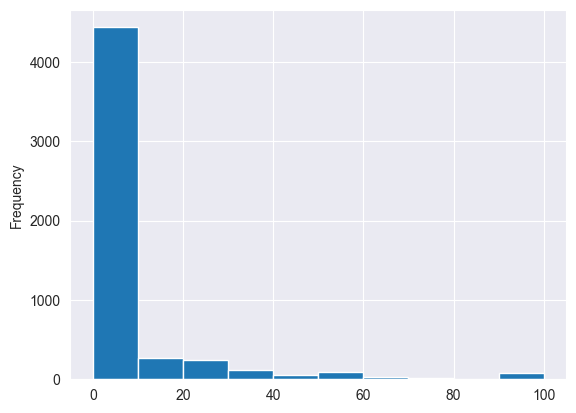

In [20]:
data2_copy['winning_perc'].plot(kind='hist')

In [21]:
data2_copy[data2_copy['total_bids_on_lots_sold'] == 0]['owner_mbr_nbr'].nunique()

3237

In [22]:
data2_copy[(data2_copy['total_lots_placed_bids_on'] > 0) & (data2_copy['total_lots_placed_bids_on'] <= 10)]['owner_mbr_nbr'].nunique()

1209

In [28]:
data2_copy[
    (data2_copy['churn'] == 1) &
    (data2_copy['total_bids_on_lots_sold'] == 0)
]['owner_mbr_nbr'].nunique()


2868

* 54% of the members who churned in June did not place any bids on the lots sold between Dec 2024 - May 2025.

In [23]:
data2_copy[data2_copy['total_bids_on_lots_sold'] == 0]

,owner_mbr_nbr,mbr_nbr,total_bids_on_lots_sold,total_lots_placed_bids_on,total_lots_won,avg_max_bid_amt,AvgSellingPrice,mbr_state,mbr_country,member_sgmnt_type,churn,winning_perc
2,505436,505436,0,0,0,0.0,0.0,VA,USA,Consumer,1,0.0
5,623557,623557,0,0,0,0.0,0.0,IA,USA,Consumer,0,0.0
7,279059,279059,0,0,0,0.0,0.0,OK,USA,Consumer,1,0.0
8,488792,488792,0,0,0,0.0,0.0,IL,USA,Consumer,1,0.0
12,80766,80766,0,0,0,0.0,0.0,NY,USA,Consumer,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5310,484864,484864,0,0,0,0.0,0.0,TX,USA,Consumer,1,0.0
5311,657678,657678,0,0,0,0.0,0.0,TN,USA,Dealer,0,0.0
5315,664419,664419,0,0,0,0.0,0.0,NJ,USA,Consumer,0,0.0
5316,504238,504238,0,0,0,0.0,0.0,NY,USA,Consumer,1,0.0
